<a href="https://colab.research.google.com/github/ChristineWeitw/RNN-Multivariate-Time-Series-Forecasting-with-LSTMs-in-Keras/blob/master/lstm_time-series-forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install scipy
!pip install tensorflow

In [28]:
!pip install q keras==2.3

In [29]:
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install matplotlib

In [8]:
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, TensorBoard

## **Data Preparation**

In [2]:
# load data
def parse(x):
  return datetime.strptime(x, '%Y %m %d %H')

dataset = read_csv('raw.csv', parse_dates = [['year','month','day','hour']],index_col=0,date_parser=parse)
dataset.drop('No',axis=1,inplace=True)

# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)

# drop the first 24 hours
dataset = dataset[24:]

# summarize first 5 rows
print(dataset.head(5))

# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


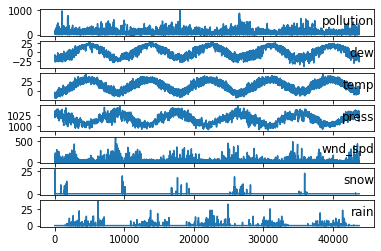

In [3]:
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv',header=0,index_col=0)
values = dataset.values
# print('values:',values)
# specify columns to plot
groups = [0,1,2,3,5,6,7]
i = 1

# plot each column
pyplot.figure()
for group in groups:
  pyplot.subplot(len(groups),1,i)
  pyplot.plot(values[:,group])
  pyplot.title(dataset.columns[group], y = 0.2, loc='right')
  i+=1

pyplot.show()

## **Multivariate LSTM Forecast Model**

In [4]:
# convert series to supervised learning

def series_to_supervised(data, n_in=1,n_out=1, dropnan=True):
  n_vars = 1 if type(data)is list else data.shape[1]
  print(n_vars)
  df = DataFrame(data)
  cols, names = list(), list()

  #input sequence (t-n, ... ,t-1)
  for i in range(n_in,0,-1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    print('input sequence - names:',names)

  # forecast sequence(t, t_1, ..., t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    print('forecast sequence - names:',names)
  
  # put it all together
  agg = concat(cols, axis=1)
  agg.columns = names

  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [5]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

8
input sequence - names: ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)']
forecast sequence - names: ['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)', 'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)', 'var6(t)', 'var7(t)', 'var8(t)']
   var1(t-1)  var2(t-1)  var3(t-1)  ...  var7(t-1)  var8(t-1)   var1(t)
1   0.129779   0.352941   0.245902  ...   0.000000        0.0  0.148893
2   0.148893   0.367647   0.245902  ...   0.000000        0.0  0.159960
3   0.159960   0.426471   0.229508  ...   0.000000        0.0  0.182093
4   0.182093   0.485294   0.229508  ...   0.037037        0.0  0.138833
5   0.138833   0.485294   0.229508  ...   0.074074        0.0  0.109658

[5 rows x 9 columns]


## **Define and Fit Model**

In [6]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


In [31]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense
from keras.layers import LSTM

Epoch 1/50
122/122 - 1s - loss: 0.0612 - val_loss: 0.0626
Epoch 2/50
122/122 - 1s - loss: 0.0441 - val_loss: 0.0688
Epoch 3/50
122/122 - 1s - loss: 0.0271 - val_loss: 0.0617
Epoch 4/50
122/122 - 1s - loss: 0.0195 - val_loss: 0.0516
Epoch 5/50
122/122 - 1s - loss: 0.0169 - val_loss: 0.0395
Epoch 6/50
122/122 - 1s - loss: 0.0158 - val_loss: 0.0303
Epoch 7/50
122/122 - 1s - loss: 0.0151 - val_loss: 0.0209
Epoch 8/50
122/122 - 1s - loss: 0.0150 - val_loss: 0.0183
Epoch 9/50
122/122 - 1s - loss: 0.0148 - val_loss: 0.0171
Epoch 10/50
122/122 - 1s - loss: 0.0148 - val_loss: 0.0157
Epoch 11/50
122/122 - 1s - loss: 0.0148 - val_loss: 0.0149
Epoch 12/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0149
Epoch 13/50
122/122 - 1s - loss: 0.0148 - val_loss: 0.0146
Epoch 14/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0147
Epoch 15/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0143
Epoch 16/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0141
Epoch 17/50
122/122 - 1s - loss: 0.0146 - val_loss: 0.0144
Epoch 

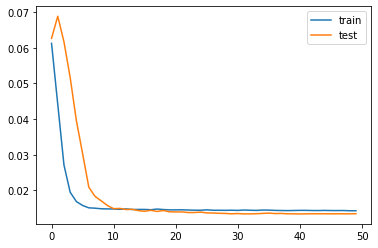

In [34]:
from tensorflow import keras
# design network
model = keras.Sequential()
model.add(layers.LSTM(50,input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## **Evaluate Model**

In [35]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 26.543
